In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import *
import numpy as np 

mu0 = 0.5
var0 = 0.1 

x = np.random.normal(2, 1, 1000)

In [2]:
Nodes = [f'a{i}' for i in range(-7, 2)] + [f'b{i}' for i in range(-7, 2)]

C_G = nx.complete_graph(Nodes)
W_G = nx.Graph()

In [3]:
for edge in C_G.edges:
    node1, node2 = edge
    if node1[0] == node2[0] == 'a':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -2**(pi+pj)*fAA(var0)
        
        W_G.add_edge(node1, node2, bij=w)
    elif node1[0] == node2[0] == 'b':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)
    else:
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)


In [4]:
node_weights = np.zeros(W_G.number_of_nodes())
for i, node in enumerate(C_G.nodes):
    if node[0] == 'a':
        p = int(node[1:])
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[i] = w
    else:
        p = int(node[1:])
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[i] = w

nx.set_node_attributes(W_G, {a:{'ai':b} for a, b in zip(C_G.nodes, node_weights)})

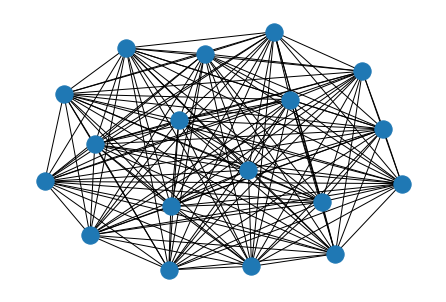

In [5]:
nx.draw(W_G)

In [11]:
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector

bqm = dimod.from_networkx_graph(W_G, vartype='BINARY', edge_attribute_name='weight', node_attribute_name='weight')

sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=1000, chain_strength=-5.0)

In [7]:
sampleset.variables

Variables(['a-1', 'a-2', 'a-3', 'a-4', 'a-5', 'a-6', 'a-7', 'a0', 'a1', 'b-1', 'b-2', 'b-3', 'b-4', 'b-5', 'b-6', 'b-7', 'b0', 'b1'])

In [12]:
theta = np.zeros(len(sampleset.record)) 
phi = np.zeros(len(sampleset.record))

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta[k] = mu
    phi[k] = var

(array([134., 173.,   0.,  77.,  93.,   0.,  80., 257.,   0.,  37., 146.]),
 array([0.484375  , 0.80326705, 1.12215909, 1.44105114, 1.75994318,
        2.07883523, 2.39772727, 2.71661932, 3.03551136, 3.35440341,
        3.67329545, 3.9921875 ]),
 <BarContainer object of 11 artists>)

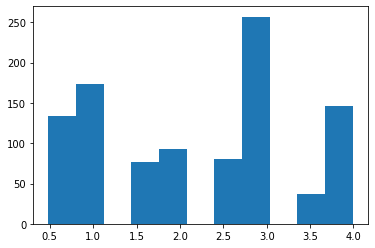

In [13]:
plt.hist(theta, bins='auto')

(array([358., 155.,  42.,   0.,   0.,   1.,   0.,   0.,  32., 274., 135.]),
 array([1.546875  , 1.76917614, 1.99147727, 2.21377841, 2.43607955,
        2.65838068, 2.88068182, 3.10298295, 3.32528409, 3.54758523,
        3.76988636, 3.9921875 ]),
 <BarContainer object of 11 artists>)

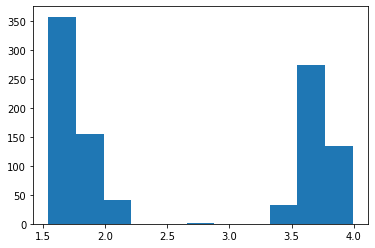

In [14]:
plt.hist(phi, bins='auto')

In [15]:
dwave.inspector.show(sampleset)

'http://127.0.0.1:18000/?problemId=479c1926-b401-449c-a8b8-4294affb3f0a'